In [8]:
import pandas as pd
import numpy as np

from statsmodels.discrete.discrete_model import Logit
# And some functions we will need
from scipy.special import logit
import matplotlib.pyplot as plt
# start by bringing in the dataset

df = pd.read_pickle("../data/set_df.pkl") 

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7257 entries, 11 to 166605
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   set_id                7257 non-null   int64         
 1   latitude              7257 non-null   float64       
 2   longitude             7257 non-null   float64       
 3   dt                    7257 non-null   datetime64[ns]
 4   elevation             7257 non-null   int32         
 5   American plaice       7257 non-null   bool          
 6   Atlantic cod          7257 non-null   bool          
 7   Atlantic herring      7257 non-null   bool          
 8   Redfish unidentified  7257 non-null   bool          
 9   American lobster      7257 non-null   bool          
 10  Snow crab             7257 non-null   bool          
dtypes: bool(6), datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 354.3 KB


In [4]:
# we'll start with redfish since they should be an easy one to predict

predictors = ['latitude', 'longitude', 'elevation']
m = Logit(df['Redfish unidentified'], df[predictors])
m = m.fit()

Optimization terminated successfully.
         Current function value: 0.278567
         Iterations 7


In [5]:
m.params


latitude     0.138898
longitude    0.182317
elevation   -0.040951
dtype: float64

In [6]:
print(m.summary2())


                           Results: Logit
Model:              Logit                Method:           MLE      
Dependent Variable: Redfish unidentified Pseudo R-squared: 0.479    
Date:               2024-04-12 15:03     AIC:              4049.1185
No. Observations:   7257                 BIC:              4069.7877
Df Model:           2                    Log-Likelihood:   -2021.6  
Df Residuals:       7254                 LL-Null:          -3876.8  
Converged:          1.0000               LLR p-value:      0.0000   
No. Iterations:     7.0000               Scale:            1.0000   
----------------------------------------------------------------------
             Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
----------------------------------------------------------------------
latitude     0.1389     0.0532     2.6126   0.0090    0.0347    0.2431
longitude    0.1823     0.0395     4.6108   0.0000    0.1048    0.2598
elevation   -0.0410     0.0014   -28.9318   0.0000 

In [10]:
df.loc[:, 'p'] = m.predict(df[predictors])

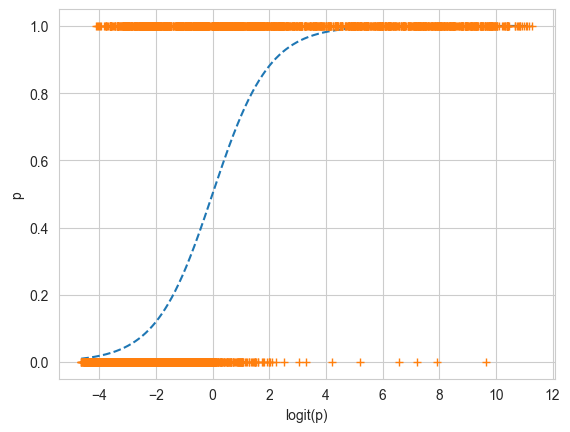

In [12]:
df = df.sort_values(by = ['p'], axis = 0)
plt.plot(logit(df.p), df.p, '--')
plt.plot(logit(df.p), df["Redfish unidentified"], '+')
plt.xlabel('logit(p)')
plt.ylabel('p')
plt.show()

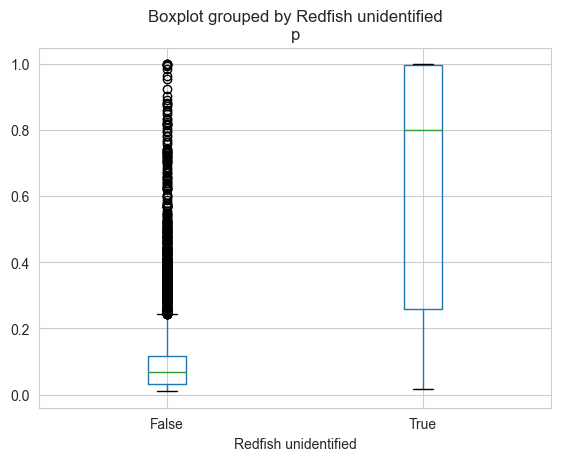

In [13]:
df.boxplot(column='p', by = 'Redfish unidentified')
plt.show()

In [14]:
df.loc[:, 'yhat'] = (df.p > 0.5) * 1
df.yhat.value_counts()

0    6078
1    1179
Name: yhat, dtype: int64

In [15]:
pd.crosstab(df["Redfish unidentified"], df.yhat)


yhat,0,1
Redfish unidentified,,
False,5502,116
True,576,1063


In [18]:
conf_mat = m.pred_table()
conf_mat

array([[5502.,  116.],
       [ 576., 1063.]])

In [19]:
tn, fp, fn, tp = conf_mat.flatten()
print (tn, fp, fn, tp)

5502.0 116.0 576.0 1063.0


In [20]:
acc = (tp + tn) / np.sum(conf_mat)
print ("Accuraccy of the model is: %1.2f" % acc)

Accuraccy of the model is: 0.90


In [21]:
mcc = (tp * tn - fp * fn)/np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))
print ("Mathews correlation coefficient between the estimates and the true response is: %1.2f" % mcc)

Mathews correlation coefficient between the estimates and the true response is: 0.71


In [22]:
prc = tp / (tp + fp)
rec = tp / (tp + fn)
print ("Model's precision is %1.2f and it's recall is %1.2f" % (prc, rec))

Model's precision is 0.90 and it's recall is 0.65


In [23]:
# Set discrimination thresholds
ths = np.arange(0., 1.0, 0.025)

# Containers
sensitivity = []
specificity = []
accuracy = []
matthews = []

# Main loop
for th in ths:
    # Generate estimates
    conf_mat = m.pred_table(threshold=th)
    
    # Extract TN, FP, ...
    tn, fp, fn, tp = conf_mat.flatten()
    
    # Calculate sensitivity and specificity
    sens = (1. * tp) / (tp + fn)
    spec = (1. * tn) / (tn + fp)    
    
    # Calculate ACC and MCC
    acc = (tp + tn) / np.sum(conf_mat)
    mcc = (tp * tn - fp * fn)/np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))    

    # Add to containers
    sensitivity.append(sens)
    specificity.append(spec)
    accuracy.append(acc)
    matthews.append(mcc)

C:\Users\fishmand\AppData\Local\Temp\1\ipykernel_15088\59817041.py:24: RuntimeWarning: invalid value encountered in scalar divide
  mcc = (tp * tn - fp * fn)/np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))


In [24]:
# Bind all the numbers together
roc = pd.DataFrame({'discret_thr' : ths, 
                    'sensitivity' : sensitivity, 
                    'specificity' : specificity,
                    '_specificity' : [1 - x for x in specificity],
                    'accuracy' : accuracy, 
                    'matthews' : matthews})

# Sort by 1 - specificity so we can plot it easily
roc = roc.sort_values(by = "_specificity")

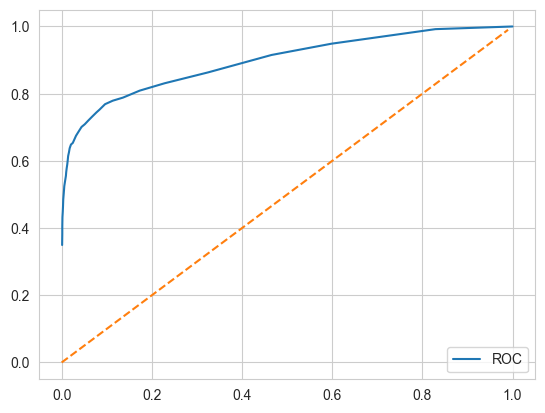

In [25]:
plt.plot(roc._specificity, roc.sensitivity, label = 'ROC')
plt.plot(np.arange(0., 1., 0.01), 
         np.arange(0., 1., 0.01), 
         '--')

plt.legend(loc = 4)

In [26]:
auc = np.trapz(y = roc.sensitivity, x = roc._specificity)
print ("Area under ROC curve = %1.2f" % auc)


Area under ROC curve = 0.90


In [27]:
# Where threshold equal 0.5
idx_default_th = np.where(roc.discret_thr == 0.5)[0][0]

# Max sum of spec and sens
idx_youdensj = np.argmax(roc.sensitivity + roc.specificity)

 # Balanced spec and sens
idx_ballance = np.argmin(np.abs(roc.sensitivity - roc.specificity))

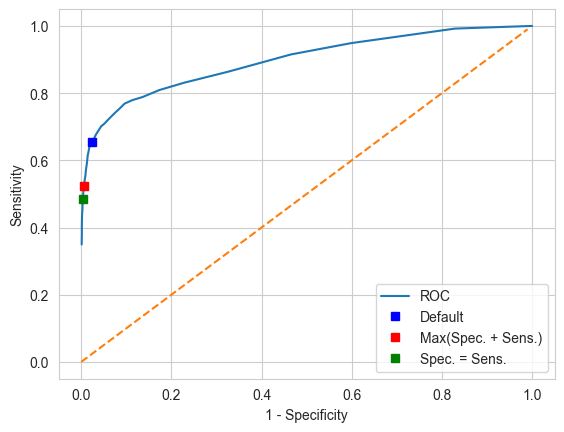

In [28]:
plt.plot(roc._specificity, roc.sensitivity, label = 'ROC')

plt.plot(np.arange(0., 1., 0.01), 
         np.arange(0., 1., 0.01), 
         '--')

plt.plot(roc._specificity[idx_default_th], 
         roc.sensitivity[idx_default_th], 
         's', color = 'blue',
         label = 'Default')

plt.plot(roc._specificity[idx_youdensj], 
         roc.sensitivity[idx_youdensj], 
         's', color = 'red',
         label = 'Max(Spec. + Sens.)')

plt.plot(roc._specificity[idx_ballance], 
         roc.sensitivity[idx_ballance], 
         's', color = 'green', 
         label = 'Spec. = Sens.')


plt.legend(loc = 4)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()


In [29]:
m.pred_table(threshold=roc.discret_thr[idx_youdensj])


array([[5585.,   33.],
       [ 779.,  860.]])

In [30]:
m.pred_table(threshold=roc.discret_thr[idx_ballance])


array([[5598.,   20.],
       [ 844.,  795.]])

In [31]:
J = max(roc.sensitivity + roc.specificity - 1)
print ('Youden\'s J = %1.2f' % J)

Youden's J = 0.67


In [32]:
print ('Odds mean: %1.2f' % np.mean(df['p']))
print ('Response mean: %1.2f' % np.mean(df['Redfish unidentified']))

Odds mean: 0.23
Response mean: 0.23


In [34]:
print ('Predicted positives #: %i' % np.sum(df['p'] > 0.5))
print ('True positives #: %i' % np.sum(df['Redfish unidentified'] > 0.5))

Predicted positives #: 1179
True positives #: 1639


In [35]:
print (conf_mat)

[[5612.    6.]
 [1066.  573.]]


In [36]:
# Predicted negatives and positives
conf_mat.sum(axis = 0)

array([6678.,  579.])

In [37]:
# Actual negatives and positives
conf_mat.sum(axis = 1)

array([5618., 1639.])

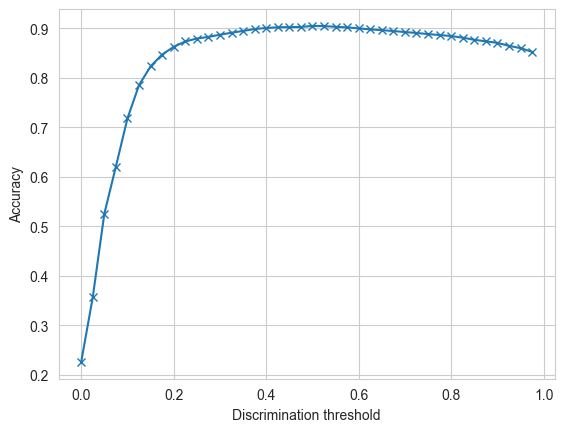

In [38]:
plt.plot(roc.discret_thr, roc.accuracy, 'x-')
plt.xlabel('Discrimination threshold')
plt.ylabel('Accuracy')
plt.show()

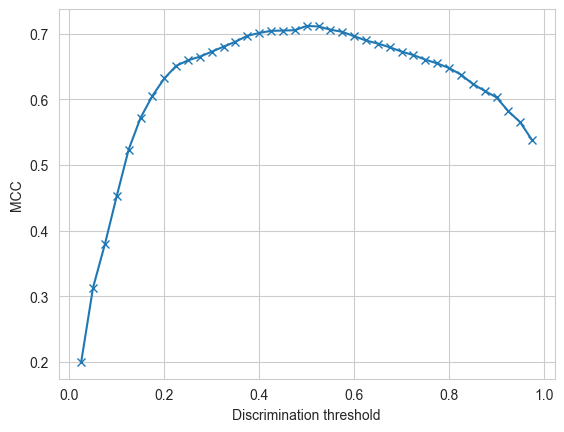

In [39]:
plt.plot(roc.discret_thr, roc.matthews, 'x-')
plt.xlabel('Discrimination threshold')
plt.ylabel('MCC')
plt.show()

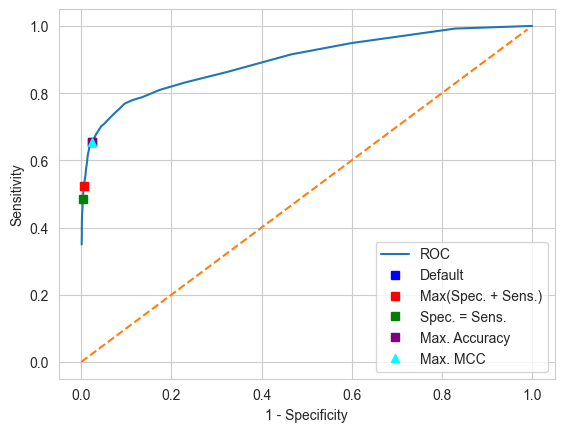

In [40]:
idx_maxacc = np.argmax(roc.accuracy)
idx_maxmcc = np.argmax(roc.matthews)

plt.plot(roc._specificity, roc.sensitivity, label = 'ROC')

plt.plot(np.arange(0., 1., 0.01), 
         np.arange(0., 1., 0.01), 
         '--')

plt.plot(roc._specificity[idx_default_th], 
         roc.sensitivity[idx_default_th], 
         's', color = 'blue',
         label = 'Default')

plt.plot(roc._specificity[idx_youdensj], 
         roc.sensitivity[idx_youdensj], 
         's', color = 'red',
         label = 'Max(Spec. + Sens.)')

plt.plot(roc._specificity[idx_ballance], 
         roc.sensitivity[idx_ballance], 
         's', color = 'green', 
         label = 'Spec. = Sens.')

plt.plot(roc._specificity[idx_maxacc], 
         roc.sensitivity[idx_maxacc], 
         's', color = 'purple',
         label = 'Max. Accuracy')

plt.plot(roc._specificity[idx_maxmcc], 
         roc.sensitivity[idx_maxmcc], 
         '^', color = 'cyan', 
         label = 'Max. MCC')

plt.legend(loc = 4)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()
